In [1]:
#Code to compute the internal energy change during impulsive encounter along straight orbit

#Computes and plots both non-perturbative and tidal limit \Delta E_{int} vs impact parameter for different values of rp/rs

#-------Created by Uddipan Banik-------

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import random
from matplotlib.patches import Rectangle
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.pylab import *
from matplotlib.colors import LogNorm
import matplotlib.ticker as mtick
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.ticker as ticker
from matplotlib.patches import BoxStyle
from scipy import integrate
from scipy import optimize
from scipy.optimize import fsolve
from scipy.interpolate import CubicSpline,interp1d
from scipy.special import erf as errorfunc
from scipy.special import gamma, factorial
from scipy.signal import argrelextrema 
from scipy.signal import savgol_filter
from matplotlib import cm
from numpy import linalg
import time
import os
import h5py
import string
from straight_functions_spherical_perturber_mass_loss import *

#-----------------------------------------------------------------



In [24]:
#-------Input parameters-------

mass_ratio=1                 #Subject mass Ms/Perturber mass Mp
q=1/mass_ratio
rp=1                         #Perturber scale radius rp in units of rs
Rc=1                         #Truncation radius in units of rs
rmax=1000000                 #Maximum radius for integration over subject profile
    
perturber_flag=3             #3: Hernquist sphere
subject_flag=2               #2: Hernquist sphere

#Impact parameter
    
impact=1                

adcorr_flag=0                #Adiabatic correction- 1: on, 0: off

gravfocusing_flag=0          #Gravitational focusing- 1: on, 0: off


if (gravfocusing_flag==0):
    
    #---Without gravitational focusing---
    
    #Velocity 
    
    vpmin=0.1                    #Minimum Perturber velocity
    vpmax=10                     #Maximum Perturber velocity
    Nvp=100
    vp=np.logspace(np.log10(vpmin),np.log10(vpmax),num=Nvp)

elif (gravfocusing_flag==1):
    
    #---With gravitational focusing---
    
    #Pericentric velocity (using simulation)
    
    vpmin=0.4                    #Minimum Perturber velocity (for plotting)
    vpmax=10**1.2                #Maximum Perturber velocity (for plotting)
    
    if (impact==1):
        Nvp=15
        
        vpMAX=np.array([ 1.215223,  1.416273,  1.79385 ,  2.168719,  2.645684,  3.131643,
        3.617455,  4.105047,  4.593905,  5.085072,  6.069781,  7.05824 ,
        8.049416,  9.041917, 10.035943])
        
        vpi=np.array([0.699636, 0.99921 , 1.498614, 1.998125, 2.497623, 2.997134,
       3.496626, 3.996146, 4.495584, 4.995161, 5.994168, 6.993195,
       7.992222, 8.991064, 9.990358])
        
        #Pericentric impact parameter (from angular momentum conservation)
        minimpact=impact*(vpi/vpMAX)
        
    elif (impact==10):
        Nvp=18
        
        vpMAX=np.array([0.809869, 0.816718,  0.857467, 0.917974,  1.149686,  1.598226,  2.072878,  2.557756,
        3.047457,  3.539862,  4.03401 ,  4.529313,  5.025552,  6.019498,
        7.014927,  8.011261,  9.007996, 10.005435])
        
        vpi=np.array([0.400411, 0.500055, 0.599817, 0.699633, 0.999207, 1.498613, 1.998126, 2.497624,
       2.997135, 3.496629, 3.996145, 4.495582, 4.995161, 5.994169,
       6.993197, 7.992223, 8.991064, 9.990355])
        
        #Pericentric impact parameter (from angular momentum conservation)
        minimpact=impact*(vpi/vpMAX)

#-----------------------------------------------------------------


In [25]:
#Loading particle data

Np=1000000                   #Total number of particles

hf=h5py.File('particle_data_hernquist_rmax1e6.h5','r')
    
X=np.array(hf.get('x'))
Y=np.array(hf.get('y'))
Z=np.array(hf.get('z'))
VX=np.array(hf.get('vx'))
VY=np.array(hf.get('vy'))
VZ=np.array(hf.get('vz'))
hf.close()

R=np.sqrt(X**2+Y**2+Z**2)
E=-0.5*(VX**2+VY**2+VZ**2)-Phi(R,subject_flag)

In [26]:
#Computing minimum encounter velocity in order to remain bound

bound_fraction=np.zeros(Nvp)                     #Bound fraction (general)
bound_fraction_tidal=np.zeros(Nvp)               #Bound fraction (distant tide- Gnedin et al. 1999)


#---For adiabatic correction---

if (adcorr_flag==1):
    
    xM1=Menc(Rc,subject_flag)
    xM2=Menc(rmax,subject_flag)
    
    Rhalf1=half_mass_radius(xM1,Rc,subject_flag)     #Half mass radius (Truncation radius 1=Rc)
    Rhalf2=half_mass_radius(xM2,rmax,subject_flag)   #Half mass radius (Truncation radius 2=rmax)
    
    Mtrunc1=Menc(Rc,subject_flag)                    #Mass (Truncation radius 1=Rc)
    Mtrunc2=Menc(rmax,subject_flag)                  #Mass (Truncation radius 2=rmax)
#------------------------------


if (gravfocusing_flag==0):
    
    #Without grav focusing
    
    delvx=vx(X,Y,Z,impact,rp,rmax,perturber_flag)
    delvy=vy(X,Y,Z,impact,rp,rmax,perturber_flag)
    #dvcm=vCM(impact,rmax,rp,rmax,perturber_flag,subject_flag)
    dvcm=np.sum(delvy)/Np
    delvcm=dvcm*np.ones(Np)
    A=delvx**2+(delvy-delvcm)**2
    B=VX*delvx+VY*(delvy-delvcm)
    
    delvxtidal=vxtidal(X,Y,Z,impact,rp,rmax,perturber_flag)
    delvytidal=vytidal(X,Y,Z,impact,rp,rmax,perturber_flag)
    delvztidal=vztidal(X,Y,Z,impact,rp,rmax,perturber_flag)
    Atidal=delvxtidal**2+delvytidal**2+delvztidal**2
    Btidal=VX*delvxtidal+VY*delvytidal+VZ*delvztidal

elif (gravfocusing_flag==1):
    
    #Grav focusing
    
    A=np.zeros((Nvp,Np))
    B=np.zeros((Nvp,Np))
    Atidal=np.zeros((Nvp,Np))
    Btidal=np.zeros((Nvp,Np))
    
    for i in range(Nvp):
        delvx=vx(X,Y,Z,minimpact[i],rp,rmax,perturber_flag)
        delvy=vy(X,Y,Z,minimpact[i],rp,rmax,perturber_flag)
        #dvcm=vCM(minimpact[i],rmax,rp,rmax,perturber_flag,subject_flag)
        dvcm=np.sum(delvy)/Np
        delvcm=dvcm*np.ones(Np)
        A[i]=delvx**2+(delvy-delvcm)**2
        B[i]=VX*delvx+VY*(delvy-delvcm)
        
        delvxtidal=vxtidal(X,Y,Z,minimpact[i],rp,rmax,perturber_flag)
        delvytidal=vytidal(X,Y,Z,minimpact[i],rp,rmax,perturber_flag)
        delvztidal=vztidal(X,Y,Z,minimpact[i],rp,rmax,perturber_flag)
        Atidal[i]=delvxtidal**2+delvytidal**2+delvztidal**2
        Btidal[i]=VX*delvxtidal+VY*delvytidal+VZ*delvztidal


In [27]:
#Computing bound fraction

for i in range(Nvp):
        
    if (adcorr_flag==1):
        if (gravfocusing_flag==0):
            adcorr=adiabatic_correction(R,impact,vp[i],Rhalf2,Mtrunc2,adcorr_flag,subject_flag)
        elif (gravfocusing_flag==1):    
            adcorr=adiabatic_correction(R,minimpact[i],vpMAX[i],Rhalf2,Mtrunc2,adcorr_flag,subject_flag)
    else:
        adcorr=1
        
    
    if (gravfocusing_flag==0):
        bound_flag1=(q/vp[i])**2*A+(q/vp[i])*B-E/(2*adcorr)
        bound_flag2=(q/vp[i])**2*Atidal+(q/vp[i])*Btidal-E/(2*adcorr)
    elif (gravfocusing_flag==1):
        bound_flag1=(q/vpMAX[i])**2*A[i]+(q/vpMAX[i])*B[i]-E/(2*adcorr)
        bound_flag2=(q/vpMAX[i])**2*Atidal[i]+(q/vpMAX[i])*Btidal[i]-E/(2*adcorr)
    
    mask=bound_flag1<0
    xbound=X[mask]
    ybound=Y[mask]
    zbound=Z[mask]
    vxbound=VX[mask]
    vybound=VY[mask]
    vzbound=VZ[mask]
    bound_fraction[i]=len(xbound)/Np
        
    masktidal=bound_flag2<0
    xbound=X[masktidal]
    ybound=Y[masktidal]
    zbound=Z[masktidal]
    vxbound=VX[masktidal]
    vybound=VY[masktidal]
    vzbound=VZ[masktidal]
    bound_fraction_tidal[i]=len(xbound)/Np

In [28]:
#Writing data in a file


hf = h5py.File('boundfraction_straight_orbit_perturber%d_subject%d_rp%.3f_massratio_%.3f_impact%.2f_rmax%.0f_adcorr%d_gravfocusing%d.h5' %(perturber_flag,subject_flag,rp,mass_ratio,impact,rmax,adcorr_flag,gravfocusing_flag), 'w')

if (gravfocusing_flag==0):
    hf.create_dataset('vp', data=vp)
elif (gravfocusing_flag==1):
    hf.create_dataset('vp', data=vpMAX)
hf.create_dataset('bound_fraction', data=bound_fraction)
hf.create_dataset('bound_fraction_tidal', data=bound_fraction_tidal)
hf.close()



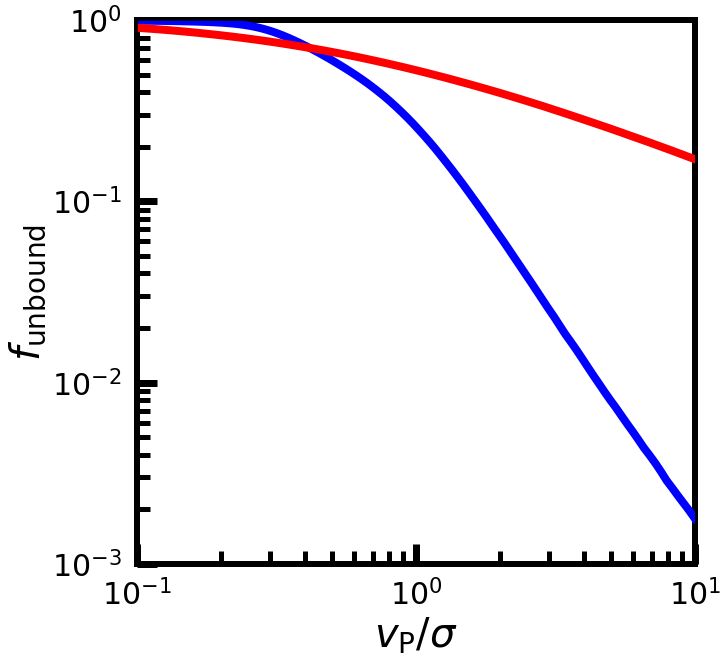

In [29]:
#Plot

fig,ax=plt.subplots(figsize=(10,10))

if (gravfocusing_flag==0):
    ax.plot(vp,1-bound_fraction,color='b',lw=8)
    ax.plot(vp,1-bound_fraction_tidal,color='r',lw=8)
elif (gravfocusing_flag==1):
    ax.plot(vpMAX,1-bound_fraction,'*',color='b',ms=20)
    ax.plot(vpMAX,1-bound_fraction_tidal,'*',color='r',ms=20)
 
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(which='major', direction='in', width=7, length=20, color='k', pad=15)
ax.tick_params(which='minor', direction='in', width=5, length=13, color='k', pad=15)
ax.set_xticks(np.logspace(np.log10(0.1),np.log10(10),num=3))
#ax.set_yticks(np.linspace(0,1,6))
ax.tick_params(labelsize=30)
ax.set_xlim([vpmin,vpmax])
ax.set_ylim([1e-3,1e0])
ax.set_xlabel('$v_{\mathrm{P}}/\sigma$',fontsize=40)
ax.set_ylabel('$f_{\mathrm{unbound}}$',fontsize=40)
ax.patch.set_edgecolor('k')  
ax.patch.set_linewidth('6')

plt.savefig('Unbound_fraction_vs_vp_straight_orbit_perturber%d_subject%d_rp%.3f_massratio_%.3f_impact%.2f_adcorr%d_gravfocusing%d.jpg'  %(perturber_flag,subject_flag,rp,mass_ratio,impact,adcorr_flag,gravfocusing_flag))
plt.show()